accuracies of my trained svms on the evaluation set, each with a different regularization constant
accuracy of svm with regularization constant of 0.001: 1.0
accuracy of svm with regularization constant of 0.01: 1.0
accuracy of svm with regularization constant of 0.1: 1.0
accuracy of svm with regularization constant of 1: 0.95


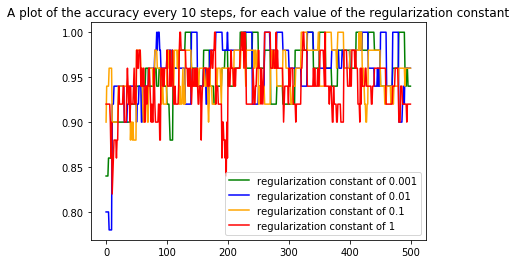

In [11]:
import random
import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

cancer_df = pd.read_table("wdbc.data", sep=',', header=None)

#data preprocessing
labels = cancer_df.iloc[:,1].values
cols = [x for x in cancer_df.columns]
cancer_df.drop([0, 1], axis = 1, inplace = True)
labels = (labels == 'M').astype(int) #1 for malignant, 0 for benign
labels = labels*2
labels = labels-1 #1 for malignant, -1 for benign
X = cancer_df.values

"""
569 examples. Separated into 100 validation, 100
test, and 369 training examples
"""
def generate_data_sets(X, labels):
    N, M = X.shape
    indices = [i for i in range(N)]
    random.shuffle(indices)
    X_train = X[indices[:369]]
    X_val = X[indices[369:469]]
    X_test = X[indices[469:]]
    y_train = labels[indices[:369]]
    y_val = labels[indices[369:469]]
    y_test = labels[indices[469:]]
    
    #normalize data
    data_mean = X_train.mean(axis=0)
    data_std = X_train.std(axis=0)
    X_train -= data_mean
    X_train /= data_std
    X_val -= data_mean
    X_val /= data_std
    X_test -= data_mean
    X_test /= data_std
    
    return X_train, X_val, X_test, y_train, y_val, y_test

#training
#The original dataset of 569 examples is split into 369 for training, 100 for validation and 100 for testing
X_train, X_val, X_test, y_train, y_val, y_test = generate_data_sets(X, labels)

def get_sample(X_set, y_set):
    N, D = X_set.shape
    choice = randint(0, N-1)
    return X_set[choice, :], y_set[choice]

def shuffle_sets(X_set, y_set):
    N, D = X_set.shape
    indices = [i for i in xrange(N)]
    random.shuffle(indices)
    return X_set[indices[:]], y_set[indices[:]]

def compute_accuracy(X_set, y_set, svm):
    N, D = X_set.shape
    
    res = np.sign(X_set.dot(svm.w) + svm.b)
    acc = np.sum(res == y_set)/N
    return acc
    
    
class SVM:
    def __init__(self, D, reg_weight = .1, weight_init='random', bias_init=1):
        self.reg = reg_weight
        if weight_init == 'random':
            self.w = np.random.rand(D)
        else:
            self.w = np.zeros(D) + weight_init
        
        self.b = bias_init

        
reg_values = [.001, .01, .1, 1]
reg_accuracies = []
svms = []

for hyperparam_idx, reg_value in enumerate(reg_values):

    N,D = X_train.shape        

    svm = SVM(D, reg_weight=reg_value, weight_init='random', bias_init=1)

    num_epochs = 50
    steps_per_epoch = 100
    num_training_held_out = 50
    steps_per_acc_log = 10
    train_accuracy = []
    losses = []

    epoch_accuracy = []
    epoch_weight_magnitude = []
    for epoch_num in range(num_epochs):
        
        X_train_eval, X_train_real, y_train_eval, y_train_real = train_test_split(X_train, y_train, test_size=319)
        
        for step_num in range(steps_per_epoch):
            
            x_k, y_k = get_sample(X_train_real, y_train_real)
            hinge_term = y_k*(svm.w.T.dot(x_k) + svm.b)
            
            #calculate training error cost which is total loss which is hinge loss with regularized penalty 
            hinge_loss = max(0,1-hinge_term)
            total_loss = hinge_loss + (reg_value/2) * (svm.w.T.dot(svm.w))

            
            #gradient descent
            #for step size, m = 1, and n = 100
            step_size = 1/(epoch_num+100)
            #if correct or incorrect we subtract the term from reg
            temp_w = svm.w - (step_size*reg_value*svm.w)
            temp_b = svm.b
            
            #based on piecewise definition of gradient
            if hinge_term < 1:
                temp_w += step_size*y_k*x_k
                temp_b += step_size*y_k
            
                
            #update our terms
            svm.w = temp_w
            svm.b = temp_b
            
            if ((step_num + 1) % steps_per_acc_log == 0):
                train_accuracy.append(compute_accuracy(X_train_eval, y_train_eval, svm))
                losses.append(total_loss)

        epoch_accuracy.append(compute_accuracy(X_train_real, y_train_real, svm))
        epoch_weight_magnitude.append(svm.w.dot(svm.w.T))
    
    reg_accuracies.append(train_accuracy)
    svms.append(svm)

"""
A plot of the accuracy every 10 steps, for each value of the regularization
constant
"""
plt.title("A plot of the accuracy every 10 steps, for each value of the regularization constant")
plt.plot(reg_accuracies[0], color='green', label='regularization constant of 0.001')
plt.plot(reg_accuracies[1], color='blue', label='regularization constant of 0.01')
plt.plot(reg_accuracies[2], color='orange',label='regularization constant of 0.1') 
plt.plot(reg_accuracies[3], color='red',label='regularization constant of 1') 
plt.legend()

print("accuracies of my trained svms on the evaluation set, each with a different regularization constant")
print("accuracy of svm with regularization constant of 0.001:",compute_accuracy(X_val, y_val, svms[0]))
print("accuracy of svm with regularization constant of 0.01:",compute_accuracy(X_val, y_val, svms[1]))
print("accuracy of svm with regularization constant of 0.1:",compute_accuracy(X_val, y_val, svms[2]))
print("accuracy of svm with regularization constant of 1:",compute_accuracy(X_val, y_val, svms[3]))